---
### Universidad de Costa Rica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas
---

- Estudiante: **Matías Leandro Flores**
- Carné: **B94199**
- Estudiante: **Gabriel Angulo Sibaja**
- Carné: **B90457**
- Estudiante: **Carlos Daniel Gómez Vargas**
- Carné: **B93319**
- Grupo: **1**


# `P5` - *Procesos M/M/s*

> El caso especial de los procesos aleatorios donde existen "estados" y "transiciones" entre estos estados, las cadenas de Markov modelan las probabilidades de transición y el tiempo de permanencia entre cada estado. En particular, la teoría de colas describe la evolución del número de elementos en la fila, dado un flujo de entrada y un flujo de salida.

---

## 1. Sistemas M/M/1

Con una tasa de llegada $\lambda$ y un parámetro de tiempo de servicio $\nu$, un proceso de Markov con un solo servidor también recibe la notación de *sistema de colas* **M/M/1** (donde la M viene de Markov). Más en general, con $s$ servidores es un sistema **M/M/s**.

La simulación de un sistema del tipo **M/M/1** implica la generación de una llegada de "clientes" como una *corriente de Poisson*. Esto es equivalente a decir que tienen una distribución de probabilidad de *tiempo entre arribos* con distribución exponencial y parámetro $\lambda$.

Por su parte, el *tiempo de servicio* tiene también una distribución exponencial pero con parámetro $\nu$. A la relación $\lambda/\nu$ usualmente se le conoce como $\rho$.

**Nota**: El tiempo de servicio se asume independiente del tiempo de llegada.

#### Sobre la simulación

Es posible crear una simulación de $N$ clientes con sus respectivos tiempos de servicio, distribuidos en el tiempo.

Para medir el tiempo se puede utilizar una medida mínima arbitraria, pero que tenga sentido para el problema. Por ejemplo: si la tasa de llegada es de 1 persona/minuto, vale más tener una granularidad de segundos o decenas de segundos para capturar una precisión temporal adecuada.

**Nota**: De la selección de $N$ puede depender la precisión deseada para el resultado. Por ejemplo: con $N = 1000$ es posible obtener una precisión de hasta el 0,001 o 0,1% ($1/N$).

### 1.1. - Problema de ejemplo: un servidor web

> Un servidor web es modelado como un sistema M/M/1 con una tasa de arribo de dos solicitudes por minuto. Es deseado tener cuatro o menos solicitudes en fila el 99\% del tiempo. ¿Qué tan rápido debe ser el servicio? $\nu$ es el parámetro de solicitudes atendidas por minuto.

El estado $i$ es el número de clientes en el sistema. La longitud de la fila es $L_q = i - 1$ (*queue length*), en virtud de la solicitud que está siendo atendida en $s = 1$ servidores. Es posible encontrar que:

$$
P( \text{5 o más clientes en el sistema} ) = \sum_{i=5}^{\infty} (1 - \rho) \rho^i  = 1 - \sum_{i=0}^{4} (1 - \rho) \rho^i = \rho^5
$$

que depende de $\rho = \lambda/\nu$ y del parámetro de servicio $\nu$ buscado. 

De los datos del problema: $\lambda = 2$. Para tener una fila de 3 o menos clientes el 99\% del tiempo se necesita:

$$
\begin{aligned}
P( \text{5 o más clientes en el sistema} ) = \rho^5 & = \left( \frac{\lambda}{\nu} \right)^5 \leq 0.01 \\
\nu^5 & \geq \frac{\lambda^5}{0.01} = \frac{2^5}{0.01} = 3200 \quad \Rightarrow \quad \nu \geq 5.024
\end{aligned}
$$

es decir, el servidor debe atender más de 5,024 solicitudes por minuto en promedio para poder satisfacer el requisito.

En la siguiente simulación, con $N = 1000$, y $\nu = 3 < 5.024$ deberíamos obtener una probabilidad $P( \text{5 o más clientes en el sistema} ) > 0.01$ que **no** cumple con las especificaciones.

**Nota**: Observar el cambio de unidades de minutos a segundos, para lograr mayor "granularidad".

Parámetro lambda = 2.0
Parámetro nu = 3.0
Tiempo con más de 3 solicitudes en fila:
	 9.56%
	 No cumple con la especificación.
Simulación es equivalente a 8.50 horas.


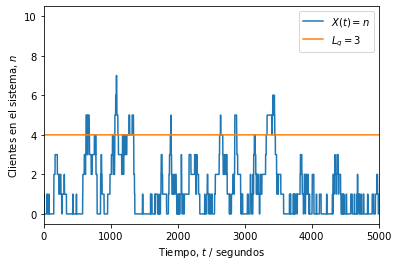

In [311]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Número de clientes
N = 1000

# Parámetro de llegada (clientes/segundos)
lam = 2/60

# Parámetro de servicio (servicios/segundos)
nu = 3/60

# Distribución de los tiempos de llegada entre cada cliente
X = stats.expon(scale = 1/lam)

# Distribución de los tiempos de servicio a cada cliente
Y = stats.expon(scale = 1/nu)

# Intervalos entre llegadas (segundos desde último cliente)
t_intervalos = np.ceil(X.rvs(N)).astype('int')

# Tiempos de las llegadas (segundos desde el inicio)
t_llegadas = [t_intervalos[0]]
for i in range(1, len(t_intervalos)):
    siguiente = t_llegadas[i-1] + t_intervalos[i]
    t_llegadas.append(siguiente)

# Tiempos de servicio (segundos desde inicio de servicio)
t_servicio = np.ceil(Y.rvs(N)).astype('int')

# Inicialización del tiempo de inicio y fin de atención
inicio = t_llegadas[0]          # primera llegada
fin = inicio + t_servicio[0]    # primera salida

# Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
# *** lo que más se modifica
t_atencion = [inicio]
for i in range(1, N):
    inicio = np.max((t_llegadas[i], fin))
    fin = inicio + t_servicio[i]
    t_atencion.append(inicio)
# ***


# Inicialización del vector temporal para registrar eventos
#print(t_atencion[-1], t_servicio[-1], "\nfin:", fin)
t = np.zeros(t_atencion[-1] + t_servicio[-1] + 1)

# Asignación de eventos de llegada (+1) y salida (-1) de clientes
for c in range(N):
    i = t_llegadas[c]
    t[i] += 1
    j = t_atencion[c] + t_servicio[c]
    t[j] -= 1

# Umbral de P o más personas en sistema (hay P - 1 en fila)
P = 5

# Instantes (segundos) de tiempo con P o más solicitudes en sistema
exceso = 0

# Proceso aleatorio (estados n = {0, 1, 2...})
Xt = np.zeros(t.shape)

# Inicialización de estado n
n = 0

# Recorrido del vector temporal y conteo de clientes (estado n)
# i: segundo actual. c: evento (+1 o -1)
for i, c in enumerate(t):
    n += c # sumar (+1) o restar (-1) al estado
    Xt[i] = n
    if Xt[i] >= P: 
        exceso += 1  # Cada vez que hay un estado por encima de umbral, contabilizar el exceso

# Fracción de tiempo con P o más solicitudes en sistema
fraccion = exceso / len(t)  # % de tiempo de exceso (con más clientes en la cola)

# Resultados
print('Parámetro lambda =', str(lam*60))
print('Parámetro nu =', str(nu*60))
print('Tiempo con más de {} solicitudes en fila:'.format(P-2))
print('\t {:0.2f}%'.format(100*fraccion))
if fraccion <= 0.01:
    print('\t Sí cumple con la especificación.')
else:
    print('\t No cumple con la especificación.') 
print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

# Gráfica de X(t) (estados del sistema)
plt.figure()
plt.plot(Xt)
plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
plt.legend(('$X(t) = n$', '$L_q = $' + str(P-2)))
plt.ylabel('Clientes en el sistema, $n$')
plt.xlabel('Tiempo, $t$ / segundos')
plt.xlim((0, 5000))
plt.show()

---
## 2. - Asignaciones

Es menester tomar una decisión con respecto al número de "servidores" necesarios para cierto proceso de vacunación, de forma tal que el sistema no exceda 50 personas en fila durante el 95% del tiempo de servicio. 

En un estudio de afluencia y del tiempo de servicio se asumen y determinan los siguientes parámetros:

- La tasa de llegada $\lambda$ es constante durante ocho horas de funcionamiento y tiene un valor de $\lambda = 4$ personas por minuto.

- La tasa de servicio $\nu$ de cada "servidor" (es decir, personal de salud tomando datos y vacunando) es constante durante ocho horas de funcionamiento y tiene un valor de $\nu = 0.25$ personas por minuto.

Entonces,

- (40%) Hacer la determinación teórica del número $s$ de servidores necesarios para cumplir el requisito.
- (60%) Modificar el código provisto para simular y corroborar el resultado anterior y crear al menos dos gráficas que muestren esta simulación.



### Parte a)
Se tiene $\lambda = 4$ y $\nu = 0.25$, lo que da $\rho = \frac{4}{0.25\cdot s} = 16/s$. La cantidad de clientes en el sistema (n) es igual a la cantidad de clientes en fila más la cantidad de clientes siendo servidos (cantidad de servidores), y en este caso, se desea que hayan máximo 50 personas en cola el 95% del tiempo. Por lo tanto la cantidad de clientes en el sistema es $n = 50 + s$ y la probabilidad de que hayan más de 50 personas en fila es igual a la probabilidad de que hayan $50+s$ personas en el sistema. 

Por lo tanto, la probabilidad de que hayan más de 50 personas en fila es de

$$
P( \text{Más de 50+s clientes en el sistema} ) = \sum_{i = 50+s+1}^{\infty}\phi_i = 1 - \sum_{i=0}^{i=50+s}\phi_i
$$, donde:
$$
\phi_i = \begin{cases}
 & \frac{(sp)^i}{i!}\phi_0 \text{ para } i < s\\ 
 & \frac{s^s\rho^i}{s!}\phi_0 \text{ para } i \geq s\\ 
\end{cases}
$$
Con:
$$
\phi_0 = \left [ \sum_{k = 0}^{s-1}\frac{(sp)^k}{k!} + \frac{(sp)^s}{s!(1-\rho)} \right ]^{-1}
$$

Para que no se exceda de 50 personas en fila en 95% del tiempo, la probabilidad de más de 50 personas en fila debe ser menor o igual a 0.05, o sea:

$$
P( \text{Más de 50+s clientes en el sistema} ) = 1 - \sum_{i=0}^{i=50+s}\phi_i \leq 0.05
$$

Sin embargo, debido a la gran cantidad de iteraciones de la sumatoria y a la no linealidad de la ecuación de $\phi_0$ no se puede despejar $s$ "a mano", por lo que la determinación teórica del número $s$ de servidores se realizó probando por inspección, empleando un script de Python que, utilizando las fórmulas mencionadas, itere sobre distintos valores de $s$ hasta encontrar el $s$ que logra una probabilidad de más de 50 personas en fila menor o igual a 0.05.

In [312]:
import math

# Definición de fórmulas necesarias
def phi_zero(s, p):
    sum = 0 
    # Sumatoria
    for k in range(0, s):  # Rango de 0 a s-1
        sum+= ((s*p)**k)/(math.factorial(k))
    add = ((s*p)**s)/((math.factorial(s))*(1-p))  # Sumar término a a sumatoria
    sum+= add
    sum = sum**-1  # Resultado de sumatoria se invierte
    return sum 

def phi_i_0(i, s, p, phi_0):  # phy_i para i < s
    formula = (((s*p)**i)/(math.factorial(i)))*phi_0
    return formula

def phi_i_1(i, s, p, phi_0):  # phy_i para i >= s
    formula = (((s**s)*(p**i))/(math.factorial(s)))*phi_0
    return formula


# Cálculo de probabilidad
s = 0
prob_50_mas = 1

# Ejecutar hasta que probabilidad de más de 50 en cola sea <= 0.05
while (prob_50_mas > 0.05):
    s+=1            # Aumentar cantidad de servidores cada iteración
    p = 4/(0.25*s)  # Calcular p (ro)
    prob_50 = 0
    n = 50+s        # Personas en el sistema = personas en cola + servidores
    if (p != 1):    # Cuando p = 1 hay indefinición del vector de probabilidad
        for i in range(0, n+1):
            # Calcular probabilidad de que hayan 50 en cola
            if (i < s):
                prob_50+= phi_i_0(i, s, p, phi_zero(s,p))
            if (i >= s):
                prob_50+= phi_i_1(i, s, p, phi_zero(s,p))
        # Probabilidad de que hayan más de 50 en cola
        prob_50_mas = 1-prob_50

print("El número de servidores para que la cantidad de personas en cola "
      'no exceda 50 el 0.95 del tiempo es de s = {} con una probabilidad de '
      '{}'.format(s, round(prob_50_mas, 4)))


El número de servidores para que la cantidad de personas en cola no exceda 50 el 0.95 del tiempo es de s = 17 con una probabilidad de 0.0335


Calculando la sumatoria de $P( \text{Más de 50+s clientes en el sistema} )$ para distintos $s$ hasta hayar el que da una probabilidad menor a 0.05, se determinó que para $s = 17$:
$$
P( \text{Más de 50 clientes en cola} ) = 1 - \sum_{i=0}^{i=50+17}\phi_i = 0.0335 \leq 0.05
$$

Es decir, a partir de $s = 17$ servidores la cantidad de personas en fila no excede 50 el 95% del tiempo.

### Parte b)
Para corrobrar que la cantidad de servidores necesaria es de 17, se modificó el código del ejemplo. Lo principal que se hizo fue crear un vector para cada uno de los servidores. Dentro de este vector se guara el tiempo que dura en salir el cliente que entró a dicho servidor. 

Si el tiempo en el que un cliente llega es menor (antes) al tiempo del servidor mínimo, entonces el cliente se debe esperar a que se vacie ese servidor, por lo que su tiempo de inicio es el tiempo del servidor mínimo. Si el tiempo en el que llega es mayor (después) que el tiempo del servidor mínimo, significa que cuando ese cliente llegue, ese servidor ya va a estar vacío, por lo que su tiempo de inicio es su tiempo de llegada. Se definió este comportamiento con una función para poder simular con distinta cantidad de servidores, como se observa a continuación.

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 16
Tiempo con más de 50 solicitudes en fila:
	 32.38%
	 No cumple con la especificación.
Simulación es equivalente a 4.48 horas.


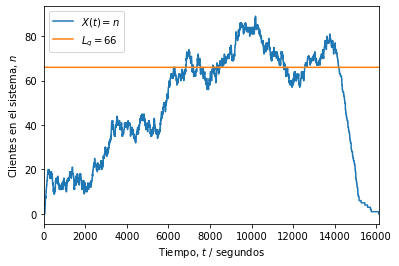

In [326]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Número de clientes
N = 1000

# Número de servidores
s = 17

# Parámetro de llegada (clientes/segundos), dividir por 60 para granularidad de segundos
lam = 4/60   

# Parámetro de servicio de cada servidor (servicios/segundos)
nu = 0.25/60

def simulacion_fila(N, s, lam, nu):
    # Distribución de los tiempos de llegada entre cada cliente
    X = stats.expon(scale = 1/lam)  # parámetro 1/lambda describe los tiempos de llegada de los clientes

    # Distribución de los tiempos de servicio a cada cliente
    Y = stats.expon(scale = 1/nu)  # parámetro 1/lambda describe los tiempos de servicio de los clientes

    # Intervalos entre llegadas (segundos desde último cliente)
    t_intervalos = np.ceil(X.rvs(N)).astype('int')

    # Tiempos de las llegadas (segundos desde el inicio) 
    t_llegadas = [t_intervalos[0]]                          # Crear lista cuyo 1er valor es primer intervalo (1er cliente)
    for i in range(1, len(t_intervalos)):                   # Va a generar N (mil) llegadas
        siguiente = t_llegadas[i-1] + t_intervalos[i]
        t_llegadas.append(siguiente)                        # Agregar tiempo de llegada de siguiente cliente

    # Tiempos de servicio (segundos desde inicio de servicio)
    t_servicio = np.ceil(Y.rvs(N)).astype('int')

    # Vector de servidores con tiempos de fin de clientes servidos
    servidores = np.zeros(s).astype('int')

    # Inicialización del tiempo de inicio y fin de atención (1er cliente)
    inicio = t_llegadas[0]          # primera llegada
    fin = inicio + t_servicio[0]    # primera salida (fin del 1er cliente es su t_llegada + su t_servicio )

    # Asignación del primer cliente en servidores
    servidores[0] = fin

    # Tiempos en que recibe atención cada i-ésimo cliente (!= que llega)
    t_atencion = [inicio]                        # Tiempo en que se atiende cada uno de los mil clientes

    for i in range(1, N):  
    
        # Asignación de servidor (se le asigna el servidor más próximo a terminar)
        t_serv_min = np.inf
        for k, t_min in enumerate(servidores):
            if t_min <= t_serv_min:
                t_serv_min = t_min             # Tiempo mínimo entre los servidores
                idx_min = k    
            
        # Si no hay desocupados
        if t_llegadas[i] < t_serv_min+1:
            inicio = t_serv_min
        # Si hay desocupados
        if t_llegadas[i] >= t_serv_min:
            inicio = t_llegadas[i]
        
        fin = inicio + t_servicio[i]               # Fin es el t_inicio + t_servicio
        t_atencion.append(inicio)                  # Concatenar tiempos de inicio para crear el tiempo de atencion
    
        # Actualización de servidor
        servidores[idx_min] = fin


    # Inicialización del vector temporal (en ceros) para registrar eventos
    # t_simulación = tiempo final máx entre los servidores al terminar de atender todos los clientes
    t = np.zeros(np.max(servidores) + 1)

    # Asignación de eventos de llegada (+1) y salida (-1) de clientes
    for c in range(N):                        
        i = t_llegadas[c]                     
        t[i] += 1                             
        j = t_atencion[c] + t_servicio[c]     
        t[j] -= 1                             

    # Umbral de exceso P son las 50 personas en fila + personas siendo servidas + 1
    P = 50+s+1    # (hay P - 1 - s en fila)

    # Instantes (segundos) de tiempo con P o más solicitudes en sistema
    exceso = 0

    # Proceso aleatorio (estados n = {0, 1, 2...})
    Xt = np.zeros(t.shape)  # Vector de zeros con la misma forma que 't'

    # Inicialización de estado n (estado = clientes en sistema)
    n = 0

    # Recorrido del vector temporal y conteo de clientes (estado n)
    for i, c in enumerate(t):
        n += c                  # sumar (+1) o restar (-1) al estado
        Xt[i] = n
        if Xt[i] >= P: 
            exceso += 1

    # Fracción de tiempo con P o más solicitudes en sistema
    fraccion = exceso / len(t)

    # Resultados
    print('Parámetro lambda =', str(lam*60))
    print('Parámetro nu =', str(nu*60))
    print('Cantidad de servidores = {}'.format(s))
    print('Tiempo con más de {} solicitudes en fila:'.format(P-s-1))
    print('\t {:0.2f}%'.format(100*fraccion))
    if fraccion <= 0.05:
        print('\t Sí cumple con la especificación.')
    else:
        print('\t No cumple con la especificación.') 
    print('Simulación es equivalente a {:0.2f} horas.'.format(len(t)/3600))

    # Gráfica de X(t) (estados del sistema)
    plt.figure()
    plt.plot(Xt)
    plt.plot(range(len(t)), (P-1)*np.ones(t.shape))
    plt.legend(('$X(t) = n$', '$L_q = $' + str(P-1)))
    plt.ylabel('Clientes en el sistema, $n$')
    plt.xlabel('Tiempo, $t$ / segundos')
    plt.xlim((0, len(t)))
    plt.show()
    
# Simulación que no cumple con las especificaciones
s = 16
simulacion_fila(N, s, lam, nu)

En la simulación previa, con $s = 16$, se puede observar que no se cumple con la especificación de una probabilidad de más de 50 solicitudes en fila menor al 5%.

A continuación se observa una simulación de $s = 17$.

Parámetro lambda = 4.0
Parámetro nu = 0.25
Cantidad de servidores = 17
Tiempo con más de 50 solicitudes en fila:
	 0.00%
	 Sí cumple con la especificación.
Simulación es equivalente a 4.41 horas.


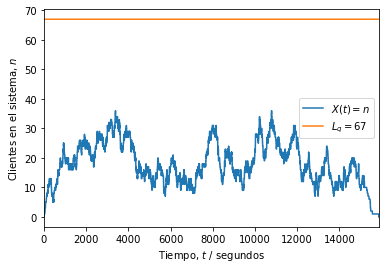

In [329]:
# Simulación que sí cumple con las especificaciones
s = 17
simulacion_fila(N, s, lam, nu)

Como se puede observar, con $s = 17$, sí se cumple con la especificación, con lo que se comprueba exitosamente la determinación del $s$ de la parte a).

---

**Universidad de Costa Rica**

Facultad de Ingeniería

Escuela de Ingeniería Eléctrica

---